### **装载云盘**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

### **安装tensorflow 2.0**

In [0]:
!pip install tensorflow-gpu==2.0.0-beta1 

In [0]:
# tensorlayer 兼容问题
!pip install imgaug==0.2.6

In [0]:
!pip install tensorlayer

### **cd命令**

In [0]:
import os
os.chdir("drive/My Drive/RL_EA/Policy_Gradient")

### **查看当前路径**

In [0]:
!pwd

/content/drive/My Drive/RL_EA/Policy_Gradient


# Policy Gradient


$$
on-Policy\\
discrete\ \&\ continous
$$ 

目的是最大化奖励的期望（利用梯度上升）：
$$
\nabla_\theta J(\pi_{\theta}) = \mathbb{E}_{\tau \sim \pi_{\theta}} \big[ \sum_{t=0}^T \nabla_\theta log \pi_{\theta}(a_t|s_t) A^{\pi_{\theta}}(s_t,a_t) \big]
$$

这里的$A$是$reward$的表达方式，可以是$Q$，或$Q-V$等。



In [0]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np

import gym
import tensorflow as tf
import tensorlayer as tl

In [0]:
##### hyper parameters #####
ENV_NAME = 'CartPole-v0'
RANDOMSEED = 1

DISPLAY_REWARD_THRESHOLD = 400
RENDER = False
EPISODES = 200

In [0]:
##### VPG #####
class PolicyGradient:

  def __init__(self, n_features, n_actions, lr=0.01, gamma=0.95):
    self.n_actions = n_actions
    self.n_features = n_features
    self.lr = lr
    self.gamma = gamma

    self.ep_obs, self.ep_as, self.ep_rs = [], [], []

    self.model = self.network([None, n_features])
    self.model.train()
    self.optimizer = tf.optimizers.Adam(self.lr)

  def network(self, inputs_shape):
    """
    网络结构模型
    inputs_shape: state_shape
    return: act
    """
    with tf.name_scope('inputs'):
      self.tf_obs = tl.layers.Input(inputs_shape, tf.float32, name="observations")
      self.tf_acts = tl.layers.Input([None,], tf.int32, "actions_num")  # 用另外的方式算-log_p时用，这里没用上
      self.tf_vt = tl.layers.Input([None,], tf.float32, "actions_value")  # 没用到
    
    # fc1
    layer = tl.layers.Dense(
        30, tf.nn.tanh, tf.random_normal_initializer(0.0, 0.3), tf.constant_initializer(0.1), name='fc1'
        )(self.tf_obs)
    # fc2
    all_act = tl.layers.Dense(
        self.n_actions, None, tf.random_normal_initializer(0.0, 0.3), tf.constant_initializer(0.1), name='all_act'
        )(layer)
    return tl.models.Model(inputs=self.tf_obs, outputs=all_act, name='PolicyGradient model')

  def choose_action_randomByBrob(self, s):
    """
    按给定概率随机选择数据
    s: state
    return: act
    """
    _logits = self.model(np.array([s], np.float32))
    _probs = tf.nn.softmax(_logits).numpy()
    # print("shape of _probs",_probs.shape)
    return tl.rein.choice_action_by_probs(_probs.ravel()) 
    # ravel() 对numpy数组进行扁平化，是原数据的一个"视图"，随原数组一同变化，flatten不变。 

  def choose_action_argmax(self, s):
    """
    greedy选择动作
    同上
    """
    _probs = tf.nn.softmax(self.model(np.array([s], np.float32))).numpy()
    # print("shape of _probs",_probs.shape)
    return np.argmax(_probs.ravel())

  def store_transition(self, s, a, r):
    """
    保存轨迹数据
    s: state
    a: act
    r: reward
    return None
    """
    self.ep_obs.append(np.array([s], np.float32))
    self.ep_as.append(a)
    self.ep_rs.append(r)
  
  def learn(self):
    """
    通过梯度上升更新策略参数
    """
    discounted_ep_rs_norm = self._discount_and_norm_rewards()

    # tf2.0里 用GradientTape记录所有在tape下的运算，用来算梯度。
    with tf.GradientTape() as tape:
      # stack:根据axis添加指定位置的一维
      # vstack：按行堆叠；hstack：按列堆叠
      _logits = self.model(np.vstack(self.ep_obs))
      # 最大化（log_p*R） == 最小化-（log_p*R），来适应tf优化
      # 得到episode的每一步的-log_p：logits->softmax * ep_as->one_hot
      neg_log_prob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=_logits, labels=np.array(self.ep_as))

      loss = tf.reduce_mean(neg_log_prob * discounted_ep_rs_norm)
    
    # tape.gradient(要微分的，其中的变量或参数，.，.)
    # tf里一般通过minimize优化，其中包含两步，第一步计算导数（梯度），第二步更新参数，
    # 两步间可能会对梯度进行人为控制（防消失，爆炸），下面两行对应minimize的两步
    grad = tape.gradient(loss, self.model.trainable_weights)
    self.optimizer.apply_gradients(zip(grad, self.model.trainable_weights))

    # 一个episode学习结束后清零再学
    self.ep_obs, self.ep_as, self.ep_rs = [], [], [] 
    return discounted_ep_rs_norm
      
  def _discount_and_norm_rewards(self):
    """
    计算折扣及归一化的rewards
    return: discounted rewards
    """
    # discount episode rewards
    discounted_ep_rs = np.zeros_like(self.ep_rs)  # zeros_like 返回一个同shape的数据结构
    running_add = 0
    for t in reversed(range(0, len(self.ep_rs))):
      running_add = running_add * self.gamma + self.ep_rs[t]
      discounted_ep_rs[t] = running_add
    # normalize
    discounted_ep_rs -= np.mean(discounted_ep_rs)
    discounted_ep_rs /= np.std(discounted_ep_rs)
    return discounted_ep_rs

  def save_ckpt(self):
    if not os.path.exists('model'):
      os.makedirs('model')
    tl.files.save_weights_to_hdf5('model/pg_policy.hdf5', self.model)

  def load_ckpt(self):
    tl.files.load_hdf5_to_weights_in_order('model/pg_policy.hdf5', self.model)


In [0]:
del RL

### **Main （初始化，训练，测试）**

In [0]:
# 初始化
np.random.seed(RANDOMSEED)
tf.random.set_seed(RANDOMSEED)

tl.logging.set_verbosity(tl.logging.DEBUG)

env = gym.make(ENV_NAME)
env.seed(RANDOMSEED)
env = env.unwrapped

print(env.action_space)
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

RL = PolicyGradient(
    n_actions=env.action_space.n,
    n_features=env.observation_space.shape[0],
    lr=0.02,
    gamma=0.99,
    # output_graph=True,
)

Episode [0/200] 	sum reward: 13 	running reward: 13.000000 	took: 0.01446s 


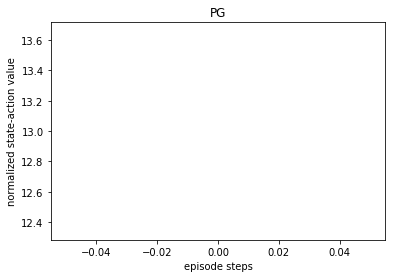

Episode [1/200] 	sum reward: 22 	running reward: 13.090000 	took: 0.02265s 
Episode [2/200] 	sum reward: 29 	running reward: 13.249100 	took: 0.02827s 
Episode [3/200] 	sum reward: 14 	running reward: 13.256609 	took: 0.01321s 
Episode [4/200] 	sum reward: 13 	running reward: 13.254043 	took: 0.01261s 
Episode [5/200] 	sum reward: 38 	running reward: 13.501502 	took: 0.03505s 
Episode [6/200] 	sum reward: 20 	running reward: 13.566487 	took: 0.02243s 
Episode [7/200] 	sum reward: 48 	running reward: 13.910823 	took: 0.05622s 
Episode [8/200] 	sum reward: 13 	running reward: 13.901714 	took: 0.01179s 
Episode [9/200] 	sum reward: 14 	running reward: 13.902697 	took: 0.01253s 
Episode [10/200] 	sum reward: 15 	running reward: 13.913670 	took: 0.01348s 


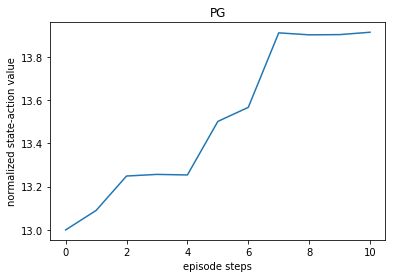

Episode [11/200] 	sum reward: 14 	running reward: 13.914534 	took: 0.01731s 
Episode [12/200] 	sum reward: 10 	running reward: 13.875388 	took: 0.01111s 
Episode [13/200] 	sum reward: 25 	running reward: 13.986634 	took: 0.02624s 
Episode [14/200] 	sum reward: 59 	running reward: 14.436768 	took: 0.05440s 
Episode [15/200] 	sum reward: 37 	running reward: 14.662400 	took: 0.03868s 
Episode [16/200] 	sum reward: 39 	running reward: 14.905776 	took: 0.04166s 
Episode [17/200] 	sum reward: 32 	running reward: 15.076719 	took: 0.02831s 
Episode [18/200] 	sum reward: 48 	running reward: 15.405951 	took: 0.04225s 
Episode [19/200] 	sum reward: 79 	running reward: 16.041892 	took: 0.07039s 
Episode [20/200] 	sum reward: 111 	running reward: 16.991473 	took: 0.11036s 


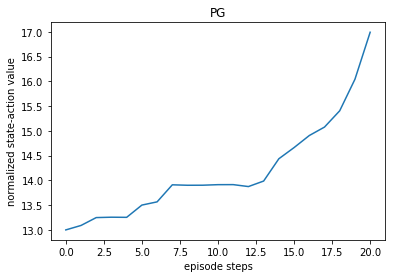

Episode [21/200] 	sum reward: 50 	running reward: 17.321558 	took: 0.06432s 
Episode [22/200] 	sum reward: 124 	running reward: 18.388343 	took: 0.13277s 
Episode [23/200] 	sum reward: 47 	running reward: 18.674459 	took: 0.05027s 
Episode [24/200] 	sum reward: 65 	running reward: 19.137715 	took: 0.06821s 
Episode [25/200] 	sum reward: 156 	running reward: 20.506337 	took: 0.17066s 
Episode [26/200] 	sum reward: 135 	running reward: 21.651274 	took: 0.14531s 
Episode [27/200] 	sum reward: 168 	running reward: 23.114761 	took: 0.18016s 
Episode [28/200] 	sum reward: 81 	running reward: 23.693614 	took: 0.08691s 
Episode [29/200] 	sum reward: 114 	running reward: 24.596678 	took: 0.13613s 
Episode [30/200] 	sum reward: 131 	running reward: 25.660711 	took: 0.13420s 


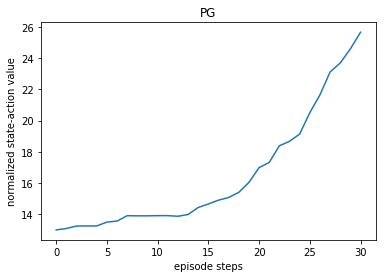

Episode [31/200] 	sum reward: 153 	running reward: 26.934104 	took: 0.15757s 
Episode [32/200] 	sum reward: 152 	running reward: 28.184763 	took: 0.16780s 
Episode [33/200] 	sum reward: 119 	running reward: 29.092915 	took: 0.12586s 
Episode [34/200] 	sum reward: 198 	running reward: 30.781986 	took: 0.21176s 
Episode [35/200] 	sum reward: 130 	running reward: 31.774166 	took: 0.13799s 
Episode [36/200] 	sum reward: 116 	running reward: 32.616424 	took: 0.13226s 
Episode [37/200] 	sum reward: 105 	running reward: 33.340260 	took: 0.11285s 
Episode [38/200] 	sum reward: 109 	running reward: 34.096858 	took: 0.12099s 
Episode [39/200] 	sum reward: 192 	running reward: 35.675889 	took: 0.22433s 
Episode [40/200] 	sum reward: 106 	running reward: 36.379130 	took: 0.11072s 


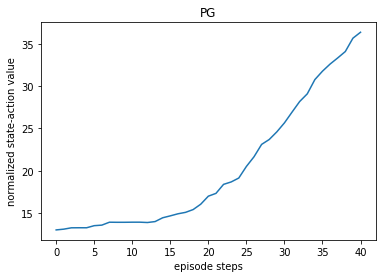

Episode [41/200] 	sum reward: 119 	running reward: 37.205339 	took: 0.12541s 
Episode [42/200] 	sum reward: 83 	running reward: 37.663285 	took: 0.08612s 
Episode [43/200] 	sum reward: 228 	running reward: 39.566653 	took: 0.24823s 
Episode [44/200] 	sum reward: 242 	running reward: 41.590986 	took: 0.26152s 
Episode [45/200] 	sum reward: 309 	running reward: 44.265076 	took: 0.33364s 
Episode [46/200] 	sum reward: 368 	running reward: 47.502425 	took: 0.39980s 
Episode [47/200] 	sum reward: 87 	running reward: 47.897401 	took: 0.09303s 
Episode [48/200] 	sum reward: 434 	running reward: 51.758427 	took: 0.44916s 
Episode [49/200] 	sum reward: 74 	running reward: 51.980843 	took: 0.07454s 
Episode [50/200] 	sum reward: 704 	running reward: 58.501034 	took: 0.73613s 


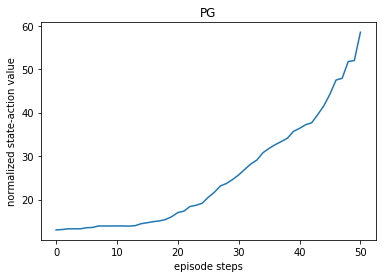

Episode [51/200] 	sum reward: 201 	running reward: 59.926024 	took: 0.21097s 
Episode [52/200] 	sum reward: 103 	running reward: 60.356764 	took: 0.11075s 
Episode [53/200] 	sum reward: 93 	running reward: 60.683196 	took: 0.09854s 
Episode [54/200] 	sum reward: 318 	running reward: 63.256364 	took: 0.33126s 
Episode [55/200] 	sum reward: 253 	running reward: 65.153801 	took: 0.26420s 
Episode [56/200] 	sum reward: 272 	running reward: 67.222263 	took: 0.29894s 
Episode [57/200] 	sum reward: 187 	running reward: 68.420040 	took: 0.19764s 
Episode [58/200] 	sum reward: 241 	running reward: 70.145840 	took: 0.25910s 
Episode [59/200] 	sum reward: 220 	running reward: 71.644381 	took: 0.23175s 
Episode [60/200] 	sum reward: 261 	running reward: 73.537937 	took: 0.28805s 


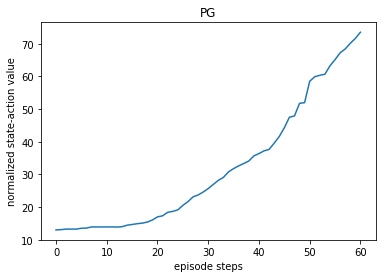

Episode [61/200] 	sum reward: 173 	running reward: 74.532558 	took: 0.18307s 
Episode [62/200] 	sum reward: 248 	running reward: 76.267232 	took: 0.26891s 
Episode [63/200] 	sum reward: 265 	running reward: 78.154560 	took: 0.28862s 
Episode [64/200] 	sum reward: 245 	running reward: 79.823014 	took: 0.26329s 
Episode [65/200] 	sum reward: 363 	running reward: 82.654784 	took: 0.39468s 
Episode [66/200] 	sum reward: 136 	running reward: 83.188236 	took: 0.14064s 
Episode [67/200] 	sum reward: 94 	running reward: 83.296354 	took: 0.10648s 
Episode [68/200] 	sum reward: 116 	running reward: 83.623391 	took: 0.12564s 
Episode [69/200] 	sum reward: 239 	running reward: 85.177157 	took: 0.25313s 
Episode [70/200] 	sum reward: 392 	running reward: 88.245385 	took: 0.43063s 


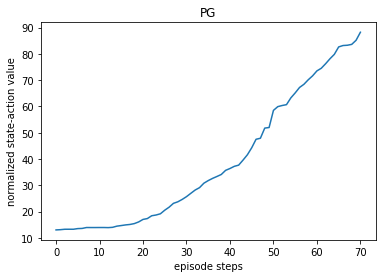

Episode [71/200] 	sum reward: 226 	running reward: 89.622931 	took: 0.24033s 
Episode [72/200] 	sum reward: 139 	running reward: 90.116702 	took: 0.14269s 
Episode [73/200] 	sum reward: 154 	running reward: 90.755535 	took: 0.17937s 
Episode [74/200] 	sum reward: 127 	running reward: 91.117980 	took: 0.13354s 
Episode [75/200] 	sum reward: 1001 	running reward: 100.216800 	took: 1.05664s 
Episode [76/200] 	sum reward: 116 	running reward: 100.374632 	took: 0.11910s 
Episode [77/200] 	sum reward: 225 	running reward: 101.620885 	took: 0.24322s 
Episode [78/200] 	sum reward: 1126 	running reward: 111.864677 	took: 1.17813s 
Episode [79/200] 	sum reward: 115 	running reward: 111.896030 	took: 0.11722s 
Episode [80/200] 	sum reward: 513 	running reward: 115.907070 	took: 0.55915s 


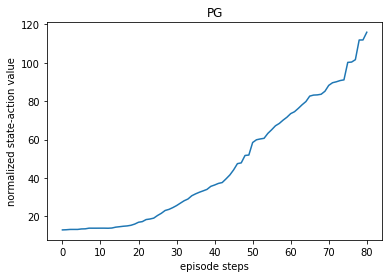

Episode [81/200] 	sum reward: 121 	running reward: 115.957999 	took: 0.12661s 
Episode [82/200] 	sum reward: 155 	running reward: 116.348419 	took: 0.15854s 
Episode [83/200] 	sum reward: 119 	running reward: 116.374935 	took: 0.13604s 
Episode [84/200] 	sum reward: 124 	running reward: 116.451185 	took: 0.13460s 
Episode [85/200] 	sum reward: 143 	running reward: 116.716673 	took: 0.15410s 
Episode [86/200] 	sum reward: 124 	running reward: 116.789507 	took: 0.12550s 
Episode [87/200] 	sum reward: 140 	running reward: 117.021612 	took: 0.14701s 
Episode [88/200] 	sum reward: 131 	running reward: 117.161396 	took: 0.14186s 
Episode [89/200] 	sum reward: 137 	running reward: 117.359782 	took: 0.14710s 
Episode [90/200] 	sum reward: 140 	running reward: 117.586184 	took: 0.15860s 


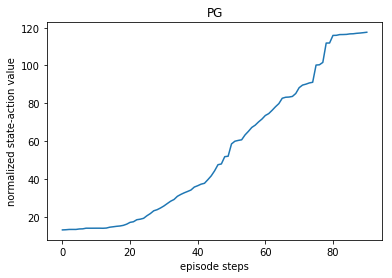

Episode [91/200] 	sum reward: 125 	running reward: 117.660322 	took: 0.12729s 
Episode [92/200] 	sum reward: 123 	running reward: 117.713719 	took: 0.12297s 
Episode [93/200] 	sum reward: 114 	running reward: 117.676582 	took: 0.11925s 
Episode [94/200] 	sum reward: 108 	running reward: 117.579816 	took: 0.10904s 
Episode [95/200] 	sum reward: 130 	running reward: 117.704018 	took: 0.14840s 
Episode [96/200] 	sum reward: 114 	running reward: 117.666977 	took: 0.12092s 
Episode [97/200] 	sum reward: 113 	running reward: 117.620308 	took: 0.12148s 
Episode [98/200] 	sum reward: 109 	running reward: 117.534105 	took: 0.11188s 
Episode [99/200] 	sum reward: 125 	running reward: 117.608763 	took: 0.13019s 
Episode [100/200] 	sum reward: 120 	running reward: 117.632676 	took: 0.12679s 


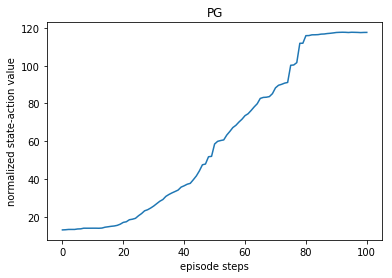

Episode [101/200] 	sum reward: 121 	running reward: 117.666349 	took: 0.13486s 
Episode [102/200] 	sum reward: 107 	running reward: 117.559686 	took: 0.10899s 
Episode [103/200] 	sum reward: 127 	running reward: 117.654089 	took: 0.13705s 
Episode [104/200] 	sum reward: 129 	running reward: 117.767548 	took: 0.12896s 
Episode [105/200] 	sum reward: 127 	running reward: 117.859872 	took: 0.13448s 
Episode [106/200] 	sum reward: 119 	running reward: 117.871274 	took: 0.12095s 
Episode [107/200] 	sum reward: 119 	running reward: 117.882561 	took: 0.12176s 
Episode [108/200] 	sum reward: 109 	running reward: 117.793735 	took: 0.12310s 
Episode [109/200] 	sum reward: 115 	running reward: 117.765798 	took: 0.12409s 
Episode [110/200] 	sum reward: 104 	running reward: 117.628140 	took: 0.10927s 


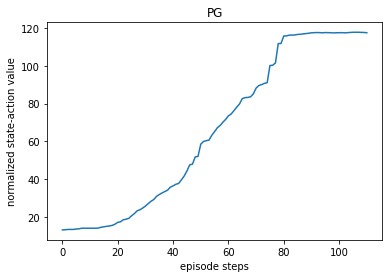

Episode [111/200] 	sum reward: 59 	running reward: 117.041859 	took: 0.06206s 
Episode [112/200] 	sum reward: 85 	running reward: 116.721440 	took: 0.08668s 
Episode [113/200] 	sum reward: 64 	running reward: 116.194226 	took: 0.06508s 
Episode [114/200] 	sum reward: 68 	running reward: 115.712283 	took: 0.08699s 
Episode [115/200] 	sum reward: 86 	running reward: 115.415160 	took: 0.09701s 
Episode [116/200] 	sum reward: 105 	running reward: 115.311009 	took: 0.11907s 
Episode [117/200] 	sum reward: 113 	running reward: 115.287899 	took: 0.11731s 
Episode [118/200] 	sum reward: 119 	running reward: 115.325020 	took: 0.12462s 
Episode [119/200] 	sum reward: 119 	running reward: 115.361770 	took: 0.12308s 
Episode [120/200] 	sum reward: 124 	running reward: 115.448152 	took: 0.12911s 


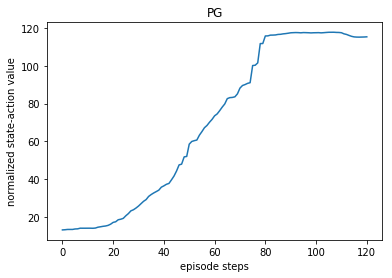

Episode [121/200] 	sum reward: 158 	running reward: 115.873670 	took: 0.16719s 
Episode [122/200] 	sum reward: 449 	running reward: 119.204934 	took: 0.49063s 
Episode [123/200] 	sum reward: 9564 	running reward: 213.652884 	took: 10.00019s 
Episode [124/200] 	sum reward: 9534 	running reward: 306.856356 	took: 10.00057s 
Episode [125/200] 	sum reward: 9621 	running reward: 399.997792 	took: 10.00127s 
Episode [126/200] 	sum reward: 9563 	running reward: 491.627814 	took: 10.00072s 
Episode [127/200] 	sum reward: 9561 	running reward: 582.321536 	took: 10.00035s 
Episode [128/200] 	sum reward: 9701 	running reward: 673.508321 	took: 10.00013s 
Episode [129/200] 	sum reward: 9537 	running reward: 762.143237 	took: 10.00059s 
Episode [130/200] 	sum reward: 9624 	running reward: 850.761805 	took: 10.00079s 


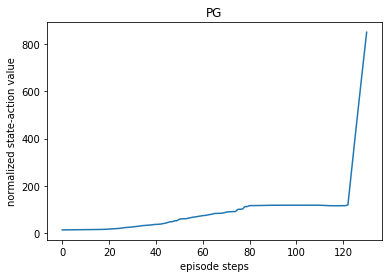

Episode [131/200] 	sum reward: 9266 	running reward: 934.914187 	took: 10.00104s 
Episode [132/200] 	sum reward: 8928 	running reward: 1014.845045 	took: 10.00021s 
Episode [133/200] 	sum reward: 9669 	running reward: 1101.386595 	took: 10.00022s 
Episode [134/200] 	sum reward: 9706 	running reward: 1187.432729 	took: 10.00014s 
Episode [135/200] 	sum reward: 9623 	running reward: 1271.788401 	took: 10.00083s 
Episode [136/200] 	sum reward: 9645 	running reward: 1355.520517 	took: 10.00063s 
Episode [137/200] 	sum reward: 9733 	running reward: 1439.295312 	took: 10.00028s 
Episode [138/200] 	sum reward: 9622 	running reward: 1521.122359 	took: 10.00010s 
Episode [139/200] 	sum reward: 9779 	running reward: 1603.701135 	took: 10.00058s 
Episode [140/200] 	sum reward: 9704 	running reward: 1684.704124 	took: 10.00031s 


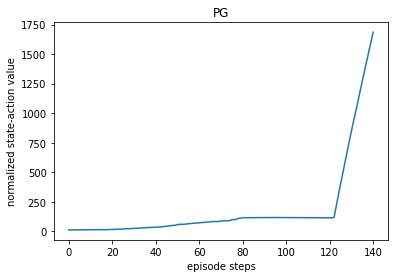

Episode [141/200] 	sum reward: 9587 	running reward: 1763.727083 	took: 10.00019s 
Episode [142/200] 	sum reward: 9663 	running reward: 1842.719812 	took: 10.00076s 
Episode [143/200] 	sum reward: 9704 	running reward: 1921.332614 	took: 10.00040s 
Episode [144/200] 	sum reward: 9720 	running reward: 1999.319288 	took: 10.00092s 
Episode [145/200] 	sum reward: 9715 	running reward: 2076.476095 	took: 10.00091s 
Episode [146/200] 	sum reward: 9656 	running reward: 2152.271334 	took: 10.00066s 
Episode [147/200] 	sum reward: 9523 	running reward: 2225.978621 	took: 10.00041s 
Episode [148/200] 	sum reward: 9646 	running reward: 2300.178834 	took: 10.00068s 
Episode [149/200] 	sum reward: 9240 	running reward: 2369.577046 	took: 10.00074s 
Episode [150/200] 	sum reward: 9749 	running reward: 2443.371276 	took: 10.00098s 


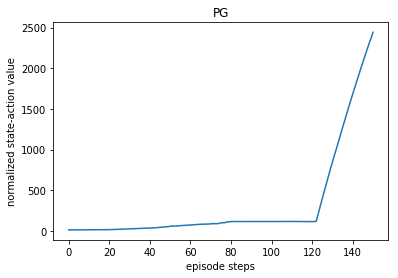

Episode [151/200] 	sum reward: 9788 	running reward: 2516.817563 	took: 10.00055s 
Episode [152/200] 	sum reward: 9753 	running reward: 2589.179387 	took: 10.00012s 
Episode [153/200] 	sum reward: 9715 	running reward: 2660.437593 	took: 10.00032s 
Episode [154/200] 	sum reward: 9656 	running reward: 2730.393217 	took: 10.00022s 
Episode [155/200] 	sum reward: 9793 	running reward: 2801.019285 	took: 10.00080s 
Episode [156/200] 	sum reward: 9808 	running reward: 2871.089092 	took: 10.00040s 
Episode [157/200] 	sum reward: 9797 	running reward: 2940.348201 	took: 10.00087s 
Episode [158/200] 	sum reward: 9776 	running reward: 3008.704719 	took: 10.00068s 
Episode [159/200] 	sum reward: 9717 	running reward: 3075.787672 	took: 10.00084s 
Episode [160/200] 	sum reward: 9776 	running reward: 3142.789796 	took: 10.00099s 


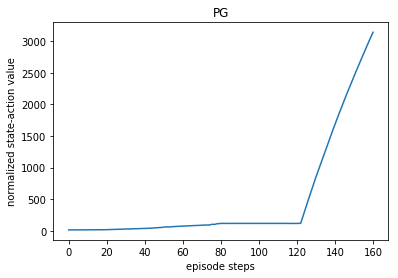

Episode [161/200] 	sum reward: 9803 	running reward: 3209.391898 	took: 10.00082s 
Episode [162/200] 	sum reward: 9336 	running reward: 3270.657979 	took: 10.00091s 
Episode [163/200] 	sum reward: 9197 	running reward: 3329.921399 	took: 10.00036s 
Episode [164/200] 	sum reward: 9779 	running reward: 3394.412185 	took: 10.00104s 
Episode [165/200] 	sum reward: 9773 	running reward: 3458.198063 	took: 10.00075s 
Episode [166/200] 	sum reward: 9727 	running reward: 3520.886082 	took: 10.00065s 
Episode [167/200] 	sum reward: 9756 	running reward: 3583.237222 	took: 10.00047s 
Episode [168/200] 	sum reward: 9767 	running reward: 3645.074849 	took: 10.00035s 
Episode [169/200] 	sum reward: 9813 	running reward: 3706.754101 	took: 10.00086s 
Episode [170/200] 	sum reward: 9862 	running reward: 3768.306560 	took: 10.00057s 


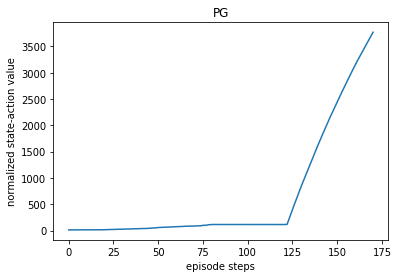

Episode [171/200] 	sum reward: 9813 	running reward: 3828.753494 	took: 10.00059s 
Episode [172/200] 	sum reward: 9858 	running reward: 3889.045959 	took: 10.00026s 
Episode [173/200] 	sum reward: 9868 	running reward: 3948.835500 	took: 10.00021s 
Episode [174/200] 	sum reward: 9859 	running reward: 4007.937145 	took: 10.00078s 
Episode [175/200] 	sum reward: 9825 	running reward: 4066.107773 	took: 10.00007s 
Episode [176/200] 	sum reward: 9895 	running reward: 4124.396695 	took: 10.00611s 
Episode [177/200] 	sum reward: 9618 	running reward: 4179.332729 	took: 10.00008s 
Episode [178/200] 	sum reward: 9820 	running reward: 4235.739401 	took: 10.00035s 
Episode [179/200] 	sum reward: 9527 	running reward: 4288.652007 	took: 10.00107s 
Episode [180/200] 	sum reward: 9671 	running reward: 4342.475487 	took: 10.00035s 


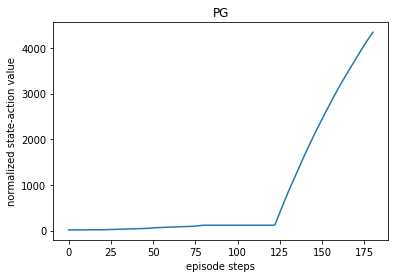

Episode [181/200] 	sum reward: 9817 	running reward: 4397.220732 	took: 10.00066s 
Episode [182/200] 	sum reward: 9834 	running reward: 4451.588525 	took: 10.00053s 
Episode [183/200] 	sum reward: 9822 	running reward: 4505.292640 	took: 10.00102s 
Episode [184/200] 	sum reward: 9809 	running reward: 4558.329713 	took: 10.00068s 
Episode [185/200] 	sum reward: 9853 	running reward: 4611.276416 	took: 10.00012s 
Episode [186/200] 	sum reward: 9889 	running reward: 4664.053652 	took: 10.00085s 
Episode [187/200] 	sum reward: 9791 	running reward: 4715.323116 	took: 10.00042s 
Episode [188/200] 	sum reward: 9890 	running reward: 4767.069884 	took: 10.00023s 
Episode [189/200] 	sum reward: 9814 	running reward: 4817.539186 	took: 10.00056s 
Episode [190/200] 	sum reward: 9927 	running reward: 4868.633794 	took: 10.00112s 


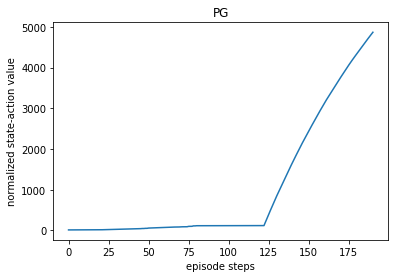

Episode [191/200] 	sum reward: 9873 	running reward: 4918.677456 	took: 10.00097s 
Episode [192/200] 	sum reward: 9854 	running reward: 4968.030681 	took: 10.00081s 
Episode [193/200] 	sum reward: 9405 	running reward: 5012.400374 	took: 10.00055s 
Episode [194/200] 	sum reward: 9431 	running reward: 5056.586371 	took: 10.00103s 
Episode [195/200] 	sum reward: 9860 	running reward: 5104.620507 	took: 10.00074s 
Episode [196/200] 	sum reward: 9829 	running reward: 5151.864302 	took: 10.00026s 
Episode [197/200] 	sum reward: 9826 	running reward: 5198.605659 	took: 10.00045s 
Episode [198/200] 	sum reward: 9850 	running reward: 5245.119602 	took: 10.00095s 


I0827 04:02:38.908528 140320161535872 tl_logging.py:99] [*] Saving TL weights into model/pg_policy.hdf5
I0827 04:02:38.923419 140320161535872 tl_logging.py:99] [*] Saved


Episode [199/200] 	sum reward: 9850 	running reward: 5291.168406 	took: 10.00081s 


In [0]:
# train
reward_buffer = []

for i_episode in range(EPISODES):

  episode_time = time.time()
  observation = env.reset()

  while True:
    if RENDER:
      env.render()

    action = RL.choose_action_randomByBrob(observation)
    # action = RL.choose_action_argmax(observation)
    observation_, reward, done, info = env.step(\)
    # 后面一个episode时间太长
    if time.time()-episode_time > 10.0:
      done = True
    RL.store_transition(observation, action, reward)

    if done:
      ep_rs_sum = sum(RL.ep_rs)

      if 'running_reward' not in globals():
        running_reward = ep_rs_sum
      else:
        running_reward = running_reward * 0.99 + ep_rs_sum * 0.01
      
      # 可视化环境太费时间，colab也看不见
      # if running_reward > DISPLAY_REWARD_THRESHOLD:
        # RENDER = True
      
      # print("episode:", i_episode, " reward:", int(running_reward))

      print(
          "Episode [%d/%d] \tsum reward: %d \trunning reward: %f \ttook: %.5fs " %
          (i_episode, EPISODES, ep_rs_sum, running_reward, time.time() - episode_time)
      )
      reward_buffer.append(running_reward)

      vt = RL.learn()
      if i_episode % 10 == 0:        
        plt.ion()
        plt.cla()
        plt.title('PG')
        plt.plot(reward_buffer, )
        plt.xlabel('episode steps')
        plt.ylabel('normalized state-action value')
        plt.show()
        plt.pause(0.1)

      break

    observation = observation_
  
RL.save_ckpt()
plt.ioff()
plt.show()  

In [0]:
# test
# 在colab上暂时运行不了可视化
RL.load_ckpt()
observation = env.reset()
for i in range(5):
#while True:
  env.render()
  action = RL.choose_action_randomByBrob(observation)
  # action = RL.choose_action_argmax(observation)
  observation, reward, done, info = env.setp(action)
  if done:
    observation = env.reset()

In [0]:
env.render()